In [1]:
import torch, math, sys

from tqdm import trange
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

from utils import data

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

torch.manual_seed(1)

In [3]:
train_input, train_targets, train_tr, train_bx = data.generate_sequences(25000, 100)
test_input, test_targets, test_tr, test_bx = data.generate_sequences(1000, 100)

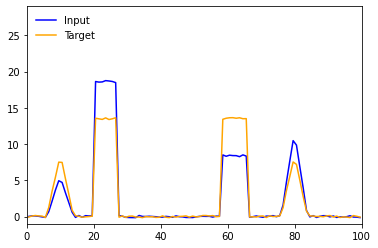

In [4]:
k = 2
data.plot_sequence_images([(train_input[k, 0], 'blue', 'Input'),
                           (train_targets[k, 0], 'orange', 'Target')])

In [7]:
in_channels = 1

model = nn.Sequential(
    nn.Conv1d(in_channels, 64, kernel_size = 5, padding = 5//2),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size = 5, padding = 5//2),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size = 5, padding = 5//2),
    nn.ReLU(),
    nn.Conv1d(64, 64, kernel_size = 5, padding = 5//2),
    nn.ReLU(),
    nn.Conv1d(64,  1, kernel_size = 5, padding = 5//2)
)
model

Sequential(
  (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): ReLU()
  (2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (3): ReLU()
  (4): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (5): ReLU()
  (6): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (7): ReLU()
  (8): Conv1d(64, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

In [9]:
nb_parameters = sum(p.numel() for p in model.parameters())
nb_parameters

62337

In [10]:
batch_size = 100
nb_epochs = 250

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
mse_loss = nn.MSELoss()

In [11]:
model.to(device)
mse_loss.to(device)
train_input, train_targets = train_input.to(device), train_targets.to(device)
test_input, test_targets = test_input.to(device), test_targets.to(device)

In [ ]:
mu, std = train_input.mean(), train_input.std()

epochs = trange(50)
for e in epochs:
    acc_loss = 0.0
    
    for input, targets in zip(train_input.split(batch_size),
                              train_targets.split(batch_size)):

        input = torch.cat((input, positional_input.expand(input.size(0), -1, -1)), 1)

        output = model((input - mu) / std)
        loss = mse_loss(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc_loss += loss.item()

    epochs.set_description(f'{e+1} {acc_loss}')
    epochs.refresh()

In [14]:
class AttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, key_channels):
        super(AttentionLayer, self).__init__()
        self.conv_Q = nn.Conv1d(in_channels, key_channels, kernel_size = 1, bias = False)
        self.conv_K = nn.Conv1d(in_channels, key_channels, kernel_size = 1, bias = False)
        self.conv_V = nn.Conv1d(in_channels, out_channels, kernel_size = 1, bias = False)

    def forward(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = Q.permute(0, 2, 1).matmul(K).softmax(2)
        x = A.matmul(V.permute(0, 2, 1)).permute(0, 2, 1)
        return x

    def __repr__(self):
        return self._get_name() + \
            '(in_channels={}, out_channels={}, key_channels={})'.format(
                self.conv_Q.in_channels,
                self.conv_V.out_channels,
                self.conv_K.out_channels
            )

    def attention(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        return Q.permute(0, 2, 1).matmul(K).softmax(2)